In [2]:
!pip install patchify

In [8]:
!pip install sewar

  Using cached sewar-0.4.5-py3-none-any.whl


# Image Preprocessing

### Imports

In [2]:
import rasterio
import os
import numpy as np
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

### Reading Tiff Image Files

In [3]:
img1 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_nrg.tif')
img2 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_p.tif')

In [4]:
full_img_1 = img1.read()
full_img_2 = img2.read()

### Visualization

In [6]:
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

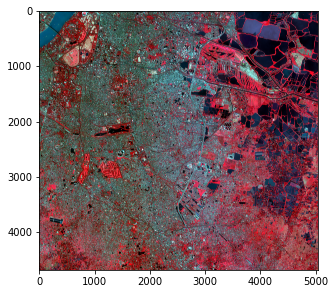

In [51]:
r = full_img_1[0]
g = full_img_1[1]
b = full_img_1[2]

rCCC = scaleCCC(r)
gCCC = scaleCCC(g)
bCCC = scaleCCC(b)

rgbCCC = np.dstack((rCCC,gCCC,bCCC))
plt.figure(figsize=(5, 5))
plt.imshow(rgbCCC)
plt.show()

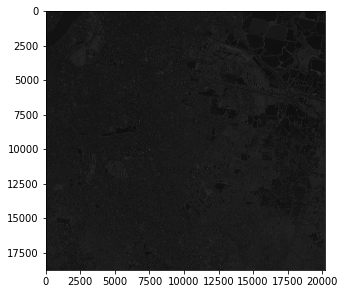

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(scaleCCC(full_img_2[0]),cmap = 'gray')
plt.show()

### Image Descriptions

In [13]:
# No. Bands
count1 = img1.count
count2 = img2.count
print('Image 1 bands: {count1} Image 2 bands: {count2}'.format(count1 = count1, count2 = count2))

Image 1 bands: 3 Image 2 bands: 1


In [10]:
img1.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 5049,
 'height': 4681,
 'count': 3,
 'crs': CRS.from_epsg(32645),
 'transform': Affine(2.8, 0.0, 635809.9893442297,
        0.0, -2.8, 2496068.408324141)}

In [11]:
img2.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 20193,
 'height': 18720,
 'count': 1,
 'crs': CRS.from_epsg(32645),
 'transform': Affine(0.7, 0.0, 635809.9893442297,
        0.0, -0.7, 2496067.008324141)}

### Creating Patches (Tiles)

In [9]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image/'):
    os.mkdir('patches/lr_image/')
    
for img in range(full_img_1.shape[0]):

    large_image = full_img_1[img]
    
    patches_img = patchify(large_image, (64, 64), step=64) 
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            tiff.imwrite('patches/lr_image/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [10]:
if not os.path.isdir('patches/hr_image/'):
    os.mkdir('patches/hr_image/')

for img in range(full_img_2.shape[0]):

    large_image = full_img_2[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            tiff.imwrite('patches/hr_image/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)

### Patches(Tiles) Visualization

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


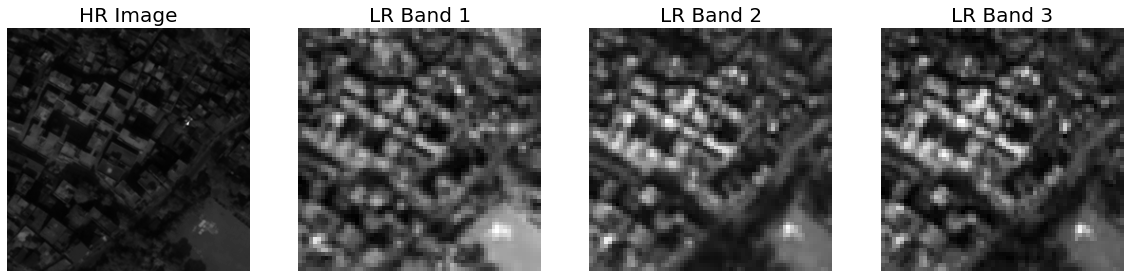

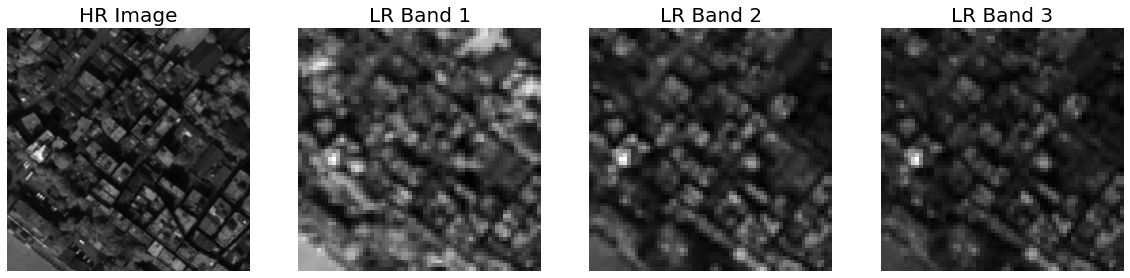

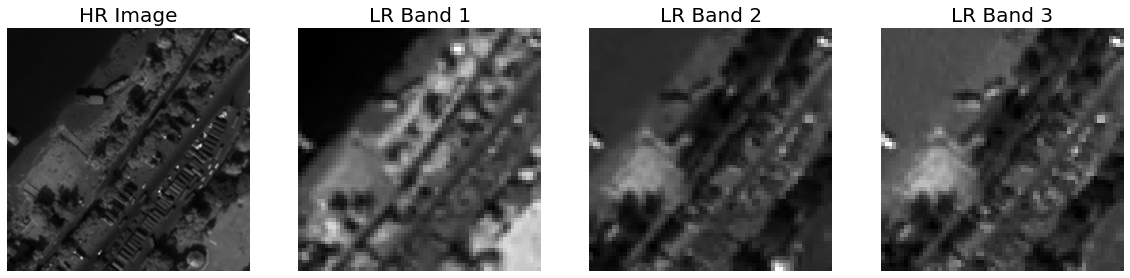

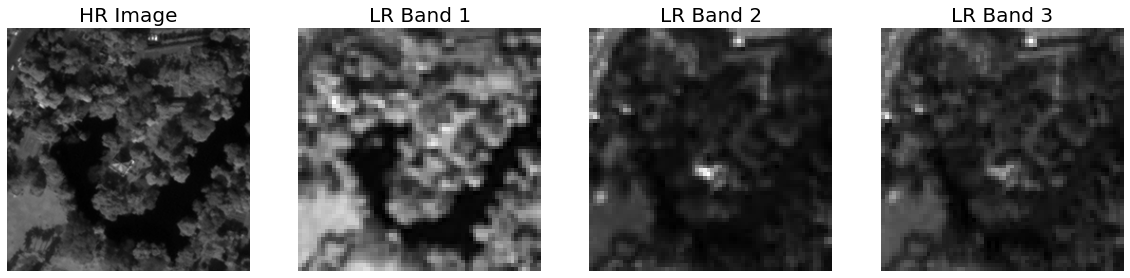

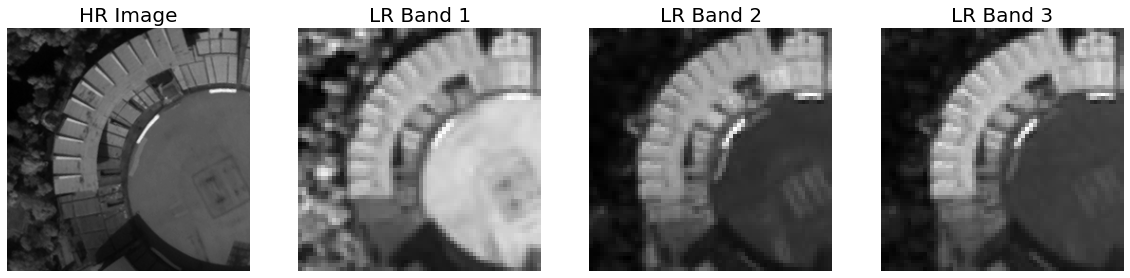

In [11]:
lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()


for hr_img in hr_list[0:5]:
    hr_img_open = rasterio.open('patches/hr_image/' + hr_img)
    lr_img_open_band_1 =  rasterio.open('patches/lr_image/' + hr_img)
    lr_img_open_band_2 =  rasterio.open('patches/lr_image/' + hr_img[:6] + '1' +hr_img[7:])
    lr_img_open_band_3 =  rasterio.open('patches/lr_image/' + hr_img[:6] + '2' +hr_img[7:])  
    hr_img_array = hr_img_open.read()
    lr_img_array_band_1 = lr_img_open_band_1.read()
    lr_img_array_band_2 = lr_img_open_band_2.read()
    lr_img_array_band_3 = lr_img_open_band_3.read()
    
    fig, axes = plt.subplots(1,4,figsize=(20,20))
    
    ax1 = axes[0]
    ax1.set_axis_off()
    ax1.imshow(scaleCCC(hr_img_array[0]),cmap = 'gray')
    ax1.set_title('HR Image',fontsize=20)
    
    ax2 = axes[1]
    ax2.set_axis_off()
    ax2.imshow(scaleCCC(lr_img_array_band_1[0]),cmap = 'gray')
    ax2.set_title('LR Band 1',fontsize=20)
    
    ax3 = axes[2]
    ax3.set_axis_off()
    ax3.imshow(scaleCCC(lr_img_array_band_2[0]),cmap = 'gray')
    ax3.set_title('LR Band 2',fontsize=20)
    
    ax4 = axes[3]
    ax4.set_axis_off()
    ax4.imshow(scaleCCC(lr_img_array_band_3[0]),cmap = 'gray')
    ax4.set_title('LR Band 3',fontsize=20)
    

    plt.show()

# Pretrained Model Testing

### Downloading Models

In [12]:
# Cloning the EDSR-SRGAN Repo
!git clone https://github.com/krasserm/super-resolution.git

# Downloading the Pre-trained EDSR model
%mkdir EDSR
%cd EDSR
!wget https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
!tar xvfz weights-edsr-16-x4.tar.gz

# Downloading the Pre-trained EDSR model
%cd ..
%mkdir SRGAN
%cd SRGAN
!wget https://martin-krasser.de/sisr/weights-srgan.tar.gz
!tar xvfz weights-srgan.tar.gz



Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/kaggle/working/EDSR
--2022-10-08 13:48:39--  https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5653330 (5.4M) [application/gzip]
Saving to: ‘weights-edsr-16-x4.tar.gz’

weights-edsr-16-x4. 100%[===================>]   5.39M  --.-KB/s    in 0.1s    

2022-10-08 13:48:40 (43.2 MB/s) - ‘weights-edsr-16-x4.tar.gz’ saved [5653330/5653330]

weights/
weights/edsr-16-x4/
weights/edsr-16-x4/weights.h5
/kaggle/working
/kaggle/worki

### Imports

In [13]:
import cv2
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
import pandas as pd

### Testing LR and HR Image Segmentation

In [14]:
%cd ..

/kaggle/working


In [15]:

lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

hr_dir = '/OriginalImages/'
lr_dir = '/LowResImages/'


if not os.path.isdir(hr_dir):
    os.mkdir(hr_dir)
else:
    shutil.rmtree(hr_dir)
    os.mkdir(hr_dir)
    
if not os.path.isdir(lr_dir):
    os.mkdir(lr_dir)
else:
    shutil.rmtree(lr_dir)
    os.mkdir(lr_dir)
    
lr_img_array_list = []
for hr_img in hr_list[0:5]:
    hr_img_open = rasterio.open('/kaggle/working/patches/hr_image/' + hr_img)
    lr_img_open_band_1 =  rasterio.open('/kaggle/working/patches/lr_image/' + hr_img)
    lr_img_open_band_2 =  rasterio.open('/kaggle/working/patches/lr_image/' + hr_img[:6] + '1' +hr_img[7:])
    lr_img_open_band_3 =  rasterio.open('/kaggle/working/patches/lr_image/'+ hr_img[:6] + '2' +hr_img[7:])  
    hr_img_array = hr_img_open.read()
    lr_img_array_band_1 = lr_img_open_band_1.read()[0]
    lr_img_array_band_2 = lr_img_open_band_2.read()[0]
    lr_img_array_band_3 = lr_img_open_band_3.read()[0]
    lr_img_array_total = np.stack([lr_img_array_band_1, lr_img_array_band_2, lr_img_array_band_3], axis=2)
    lr_img_array_total = cv2.normalize(lr_img_array_total, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    hr_img_array_total = cv2.normalize(hr_img_array, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    lr_img_array_list.append(lr_img_array_total)
    cv2.imwrite(hr_dir + hr_img, hr_img_array_total[0])
    cv2.imwrite(lr_dir + hr_img, lr_img_array_total)

In [16]:
lr_img_array_list[0].shape

(64, 64, 3)

In [17]:
if  os.path.isdir('/results'):
    shutil.rmtree('/results')
os.mkdir('/results')
images = hr_list[0:5]

### EDSR

In [18]:
%cd kaggle/working 

[Errno 2] No such file or directory: 'kaggle/working'
/kaggle/working


In [18]:
%pwd

'/kaggle/working'

In [18]:
### EDSR Model
#%cd ..
%cd super-resolution
from model.common import resolve
from model.edsr import edsr
from utils import load_image, plot_sample

model = edsr(scale=4, num_res_blocks=16)

%cd ..
model.load_weights('EDSR/weights/edsr-16-x4/weights.h5')
sr = resolve(model, lr_img_array_list)

/kaggle/working/super-resolution


2022-10-08 13:48:47.429310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:48:47.533890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:48:47.534704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 13:48:47.536675: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

/kaggle/working


2022-10-08 13:48:51.116459: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [19]:
# EDSR Results
if not os.path.isdir('results/'):
    os.mkdir('results/')

results_edsr = '/results/EDSR/'
if not os.path.isdir(results_edsr):
    os.mkdir(results_edsr)

for img,img_array in zip(images,sr):
    cv2.imwrite(results_edsr + img, img_array.numpy())

### SRGAN

In [20]:
### SRGAN Model
%cd super-resolution
from model.common import resolve
from model.srgan import generator, discriminator
from utils import load_image, plot_sample

pre_generator = generator()
gan_generator = generator()

%cd ..
pre_generator.load_weights('SRGAN/weights/srgan/pre_generator.h5')
gan_generator.load_weights('SRGAN/weights/srgan/gan_generator.h5')
pre = resolve(pre_generator, lr_img_array_list)
gan = resolve(gan_generator, lr_img_array_list)

/kaggle/working/super-resolution
/kaggle/working


In [21]:
# SRGAN Results

results_pre = '/results/PRE/'
results_gan = '/results/GAN/'
if not os.path.isdir(results_gan):
    os.mkdir(results_gan)
    
if not os.path.isdir(results_pre):
    os.mkdir(results_pre)

for img,img_array in zip(images,pre):
    cv2.imwrite(results_pre + img, img_array.numpy())
    
for img,img_array in zip(images,gan):
    cv2.imwrite(results_gan + img, img_array.numpy())

In [22]:
# import modules
import cv2
import numpy as np
import math
import sys
import time


# Interpolation kernel
def u(s, a):
	if (abs(s) >= 0) & (abs(s) <= 1):
		return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
	elif (abs(s) > 1) & (abs(s) <= 2):
		return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
	return 0


# Padding
def padding(img, H, W, C):
	zimg = np.zeros((H+4, W+4, C))
	zimg[2:H+2, 2:W+2, :C] = img
	
	# Pad the first/last two col and row
	zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
	zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
	zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
	zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
	
	# Pad the missing eight points
	zimg[0:2, 0:2, :C] = img[0, 0, :C]
	zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
	zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
	zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
	return zimg


# Bicubic operation
def bicubic(img, ratio, a):
	
	# Get image size
	H, W, C = img.shape
	
	# Here H = Height, W = weight,
	# C = Number of channels if the
	# image is coloured.
	img = padding(img, H, W, C)
	
	# Create new image
	dH = math.floor(H*ratio)
	dW = math.floor(W*ratio)

	# Converting into matrix
	dst = np.zeros((dH, dW, 3))
	# np.zeroes generates a matrix
	# consisting only of zeroes
	# Here we initialize our answer
	# (dst) as zero

	h = 1/ratio

	inc = 0
	
	for c in range(C):
		for j in range(dH):
			for i in range(dW):
				
				# Getting the coordinates of the
				# nearby values
				x, y = i * h + 2, j * h + 2

				x1 = 1 + x - math.floor(x)
				x2 = x - math.floor(x)
				x3 = math.floor(x) + 1 - x
				x4 = math.floor(x) + 2 - x

				y1 = 1 + y - math.floor(y)
				y2 = y - math.floor(y)
				y3 = math.floor(y) + 1 - y
				y4 = math.floor(y) + 2 - y
				
				# Considering all nearby 16 values
				mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
				mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
									img[int(y-y2), int(x-x1), c],
									img[int(y+y3), int(x-x1), c],
									img[int(y+y4), int(x-x1), c]],
								[img[int(y-y1), int(x-x2), c],
									img[int(y-y2), int(x-x2), c],
									img[int(y+y3), int(x-x2), c],
									img[int(y+y4), int(x-x2), c]],
								[img[int(y-y1), int(x+x3), c],
									img[int(y-y2), int(x+x3), c],
									img[int(y+y3), int(x+x3), c],
									img[int(y+y4), int(x+x3), c]],
								[img[int(y-y1), int(x+x4), c],
									img[int(y-y2), int(x+x4), c],
									img[int(y+y3), int(x+x4), c],
									img[int(y+y4), int(x+x4), c]]])
				mat_r = np.matrix(
					[[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
				
				# Here the dot function is used to get
				# the dot product of 2 matrices
				dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

	# If there is an error message, it
	# directly goes to stderr
	sys.stderr.write('\n')
	
	# Flushing the buffer
	sys.stderr.flush()
	return dst



# Scale factor
ratio = 4
# Coefficient
a = -1/4


In [23]:
results_bicubic = '/results/Bicubic/'
img_path = '/LowResImages/'

if not os.path.isdir(results_bicubic):
    os.mkdir(results_bicubic)

for img_name in images:

    
    img = rasterio.open(img_path+img_name)
    img = img.read()
    r = img[0]
    g = img[1]
    b = img[2]
    img = np.stack([r,g,b],axis = 2)

    dst = bicubic(img, ratio, a)
#     print(dst.shape)
#     r1 = dst[:,:,0]
#     g1 = dst[:,:,1]
#     b1 = dst[:,:,2]
#     img_new = np.stack([r1,g1,b1],axis = 0)
    img_new = cv2.normalize(dst, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite(results_bicubic + img_name, img_new)

### Image Visualization

In [25]:
%ls

EDSR/  SRGAN/  __notebook_source__.ipynb  patches/  results/  super-resolution/


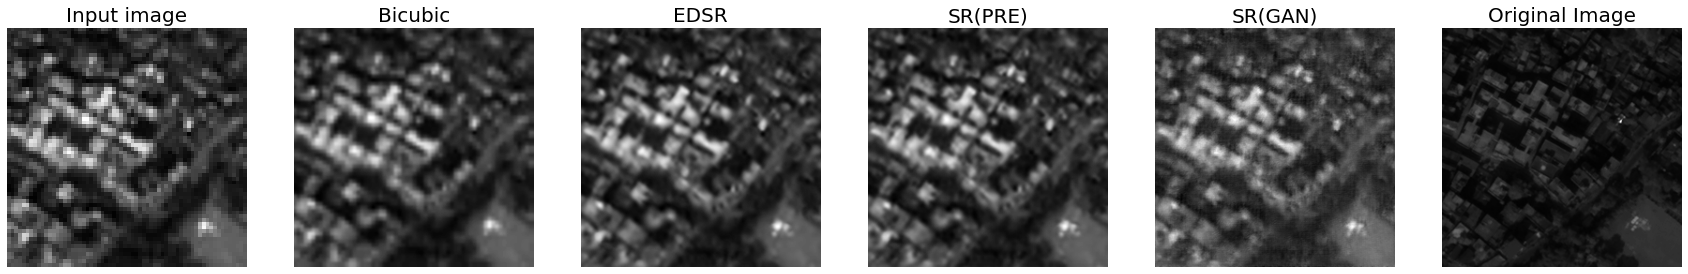

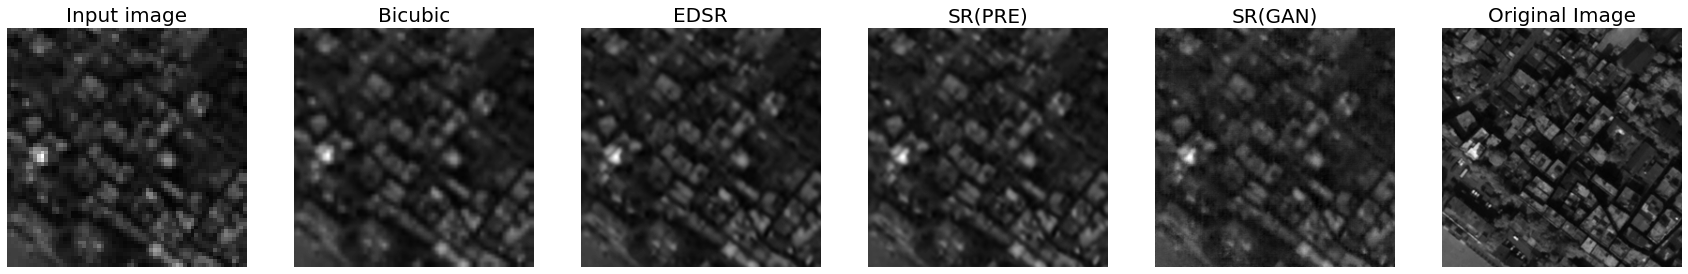

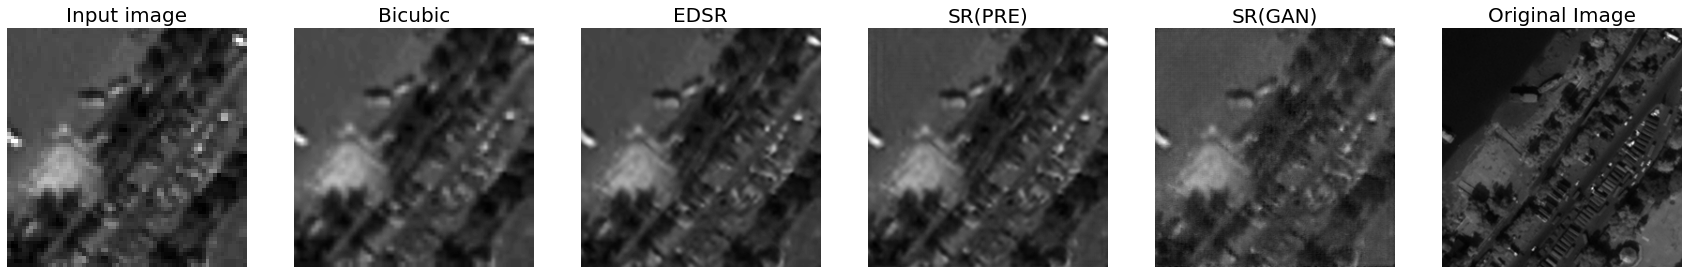

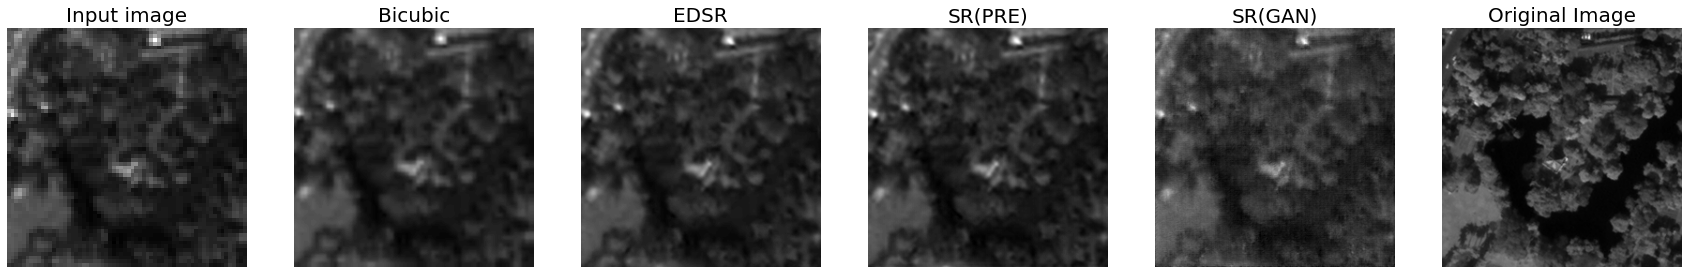

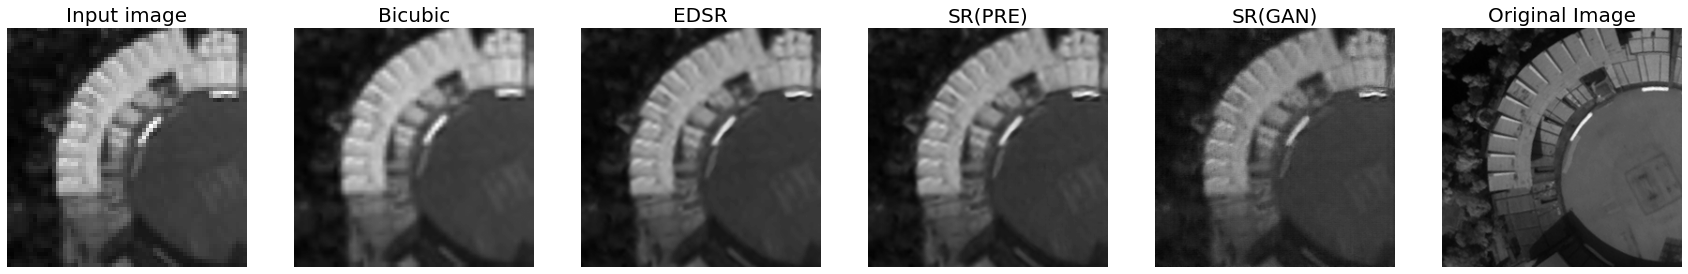

In [24]:
###  Image visualizations

# Display setup
def display(img1,img2,img3,img4, img5,img6):
    
  fig = plt.figure(figsize=(30, 15))

  ax1 = fig.add_subplot(1, 6, 1) 
  plt.title('Input image', fontsize=20)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 6, 2)
  plt.title('Bicubic', fontsize=20)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, 6, 3) 
  plt.title('EDSR', fontsize=20)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, 6, 4)
  plt.title('SR(PRE)', fontsize=20)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, 6, 5)
  plt.title('SR(GAN)', fontsize=20)
  ax5.axis('off')
  ax6 = fig.add_subplot(1, 6, 6)
  plt.title('Original Image', fontsize=20)
  ax6.axis('off')
  ax1.imshow(img1,cmap = 'gray')
  ax2.imshow(img2,cmap = 'gray')
  ax3.imshow(img3,cmap = 'gray')
  ax4.imshow(img4,cmap = 'gray')
  ax5.imshow(img5,cmap = 'gray')
  ax6.imshow(img6,cmap = 'gray')

def imread(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  r = img[0]
  g = img[1]
  b = img[2]
  rCCC = scaleCCC(r)
  gCCC = scaleCCC(g)
  bCCC = scaleCCC(b)
  img = np.dstack((rCCC,gCCC,bCCC))
  return img

def imread_bi(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  r = img[2]
  g = img[1]
  b = img[0]
  rCCC = scaleCCC(r)
  gCCC = scaleCCC(g)
  bCCC = scaleCCC(b)
  img = np.dstack((rCCC,gCCC,bCCC))
  return img

def imread_hr(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  img = img[0]
  return img

def imread_hr_bi(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  img = img[2]
  return img

# Input and results folder
input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR/'
result_presrgan = '/results/PRE/'
result_srgan =  '/results/GAN/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)
    


# Print images
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread(out_edsr)
  img_pre = imread(out_pre)
  img_gan = imread(out_gan)
  img_bi = imread_bi(out_bi)
  display(img_input[:,:,0],img_bi[:,:,0],img_edsr[:,:,0],img_pre[:,:,0],img_gan[:,:,0],img_original)

### Peak Signal-to-Noise Ratio (PSNR) Comparison:

In [27]:
from math import log10, sqrt

psnr_list = []

input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR/'
result_presrgan = '/results/PRE/'
result_srgan =  '/results/GAN/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)
    
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def psnr(original_img,img1,img2,img3,img4):
    psnr1 = PSNR(original_img, img1)
    psnr2 = PSNR(original_img, img2)
    psnr3 = PSNR(original_img, img3)
    psnr4 = PSNR(original_img, img4)
    psnr_list.append([psnr1,psnr2,psnr3,psnr4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  psnr(img_original,img_bi,img_edsr,img_pre,img_gan)

psnr_array = np.array(psnr_list)
psnr_array = np.append(psnr_array, np.mean(psnr_list,axis = 0).reshape(1,4),axis = 0)
    
df_psnr = pd.DataFrame(psnr_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_psnr['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_psnr['Avg'] = np.mean(psnr_array,axis = 1)
df_psnr.set_index('Images',inplace = True)
df_psnr.style.set_caption("PSNR Table")

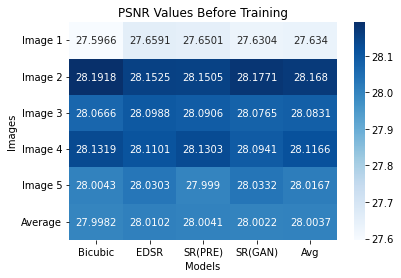

In [28]:
import seaborn as sns
ax = sns.heatmap(df_psnr, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='PSNR Values Before Training')

### Structural Similarity Index (SSIM) Comperison:

In [79]:
from skimage.metrics import structural_similarity
score = []


input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR/'
result_presrgan = '/results/PRE/'
result_srgan =  '/results/GAN/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)

def ssim(original_img,img1,img2,img3,img4):
    score1 = structural_similarity(original_img, img1, data_range=img1.max() - img1.min())
    score2 = structural_similarity(original_img, img2, data_range=img2.max() - img2.min())
    score3 = structural_similarity(original_img, img3, data_range=img3.max() - img3.min())
    score4 = structural_similarity(original_img, img4, data_range=img4.max() - img4.min())
    score.append([score1,score2,score3,score4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  ssim(img_original,img_bi,img_edsr,img_pre,img_gan)

ssim_array = np.array(score)
ssim_array = np.append(ssim_array, np.mean(score,axis = 0).reshape(1,4),axis = 0)
    
df_ssim = pd.DataFrame(ssim_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_ssim['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_ssim['Avg'] = np.mean(ssim_array,axis = 1)
df_ssim.set_index('Images',inplace = True)
df_ssim.style.set_caption("SSIM Table")

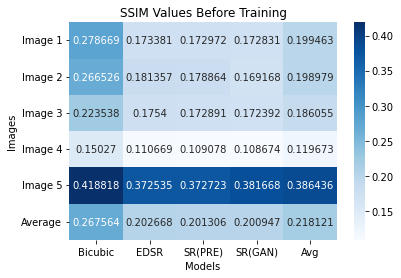

In [88]:
import seaborn as sns
ax = sns.heatmap(df_ssim, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='SSIM Values Before Training')

### Root Mean Squered Error (RMSE) Comperison:

In [85]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
score = []

input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR/'
result_presrgan = '/results/PRE/'
result_srgan =  '/results/GAN/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)

def err(original_img,img1,img2,img3,img4):
    score1 = rmse(original_img, img1)
    score2 = rmse(original_img, img2)
    score3 = rmse(original_img, img3)
    score4 = rmse(original_img, img4)
    
    score.append([score1,score2,score3,score4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  err(img_original,img_bi,img_edsr,img_pre,img_gan)

rmse_array = np.array(score)
rmse_array = np.append(rmse_array, np.mean(score,axis = 0).reshape(1,4),axis = 0)
    
df_rmse = pd.DataFrame(rmse_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_rmse['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_rmse['Avg'] = np.mean(rmse_array,axis = 1)
df_rmse.set_index('Images',inplace = True)
df_rmse.style.set_caption("RMSE Table")

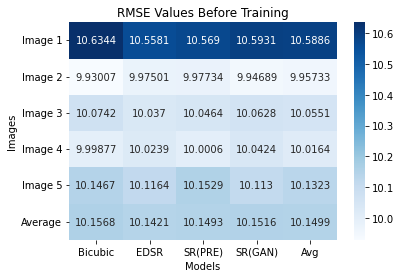

In [87]:
import seaborn as sns
ax = sns.heatmap(df_rmse, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='RMSE Values Before Training')

# Transfer Learning

### Re-adjusting images for TL

In [25]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image_training/'):
    os.mkdir('patches/lr_image_training/')
    
for img in range(full_img_1.shape[0]):

    large_image = full_img_1[img]
    
    patches_img = patchify(large_image, (24, 24), step=24) 
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            tiff.imwrite('patches/lr_image_training/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [26]:
if not os.path.isdir('patches/hr_image_training/'):
    os.mkdir('patches/hr_image_training/')

for img in range(full_img_2.shape[0]):

    large_image = full_img_2[img]
    
    patches_img = patchify(large_image, (96, 96), step=96)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            tiff.imwrite('patches/hr_image_training/' + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [27]:
hr_dir_train = '/OriginalImages_Training/'
lr_dir_train = '/LowResImages_Training/'


if not os.path.isdir(hr_dir_train):
    os.mkdir(hr_dir_train)
else:
    shutil.rmtree(hr_dir_train)
    os.mkdir(hr_dir_train)

if not os.path.isdir(lr_dir_train):
    os.mkdir(lr_dir_train)
else:
    shutil.rmtree(lr_dir_train)
    os.mkdir(lr_dir_train)
    
hr_list = os.listdir('patches/hr_image_training/')

for hr_img in hr_list:
    hr_img_open = rasterio.open('/kaggle/working/patches/hr_image_training/' + hr_img)
    lr_img_open_band_1 =  rasterio.open('/kaggle/working/patches/lr_image_training/' + hr_img)
    lr_img_open_band_2 =  rasterio.open('/kaggle/working/patches/lr_image_training/' + hr_img[:6] + '1' +hr_img[7:])
    lr_img_open_band_3 =  rasterio.open('/kaggle/working/patches/lr_image_training/'+ hr_img[:6] + '2' +hr_img[7:])  
    hr_img_array = hr_img_open.read()
    hr_img_array_total = np.stack([hr_img_array[0], hr_img_array[0], hr_img_array[0]], axis=2)
    lr_img_array_band_1 = lr_img_open_band_1.read()[0]
    lr_img_array_band_2 = lr_img_open_band_2.read()[0]
    lr_img_array_band_3 = lr_img_open_band_3.read()[0]
    lr_img_array_total = np.stack([lr_img_array_band_1, lr_img_array_band_2, lr_img_array_band_3], axis=2)
    lr_img_array_total = cv2.normalize(lr_img_array_total, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    hr_img_array_total = cv2.normalize(hr_img_array_total, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite(hr_dir_train + hr_img, hr_img_array_total)
    cv2.imwrite(lr_dir_train + hr_img, lr_img_array_total)

### Helper Functions (Image Processing)

In [28]:
def read_lr_image(path):
    path = path.decode()
    img = rasterio.open(path)
    lr_img_array  = img.read()
    x = np.stack([lr_img_array[0],lr_img_array[1],lr_img_array[2]],axis = 2)
    return x
def read_hr_image(path):
    path = path.decode()
    img = rasterio.open(path)
    hr_img_array = img.read()
    y = np.stack([hr_img_array[0],hr_img_array[1],hr_img_array[2]],axis = 2)
    return y

In [29]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_lr_image(x)
        y = read_hr_image(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.uint8, tf.uint8])
    return x, y

In [30]:
import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE

def tf_dataset(X, Y, batch=3):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [31]:
tot_images = len(os.listdir(hr_dir_train))
train_images = int(np.round(tot_images*0.7))
val_images = int(np.round(tot_images*0.2))

### Training - Validation Split

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

NUM_TRAIN_IMAGES = train_images
NUM_VAL_IMAGES = val_images

train_x = sorted(glob.glob(os.path.join(lr_dir_train, "*")))[:NUM_TRAIN_IMAGES]
train_y = sorted(glob.glob(os.path.join(hr_dir_train, "*")))[:NUM_TRAIN_IMAGES]
    
train_x, train_y = shuffle(train_x, train_y, random_state=10)

valid_x =  sorted(glob.glob(os.path.join(lr_dir_train, "*"))) [
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES ]
valid_y = sorted(glob.glob(os.path.join(hr_dir_train, "*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES ]

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 26292 - 26292
Valid: 7512 - 7512


In [33]:
batch_size = 20

ds = tf_dataset(train_x,train_y,batch_size)

# ds = tf.data.Dataset.zip((lr_images,hr_images))
# ds = ds.batch(batch_size)
# ds = ds.repeat(repeat_count)
# ds = ds.prefetch(buffer_size=AUTOTUNE)

### Training SRGAN

In [34]:
%cd super-resolution
from model.common import resolve
from model.srgan import generator, discriminator
from train import SrganTrainer

gan_generator = generator()
discriminator=discriminator()

%cd ..
gan_generator.load_weights('SRGAN/weights/srgan/gan_generator.h5')
discriminator.load_weights('SRGAN/weights/srgan/gan_discriminator.h5')

if not os.path.isdir('SRGAN/weights_new/'):
    os.mkdir('SRGAN/weights_new/')

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator)
gan_trainer.train(ds, steps=1000)

gan_trainer.generator.save_weights('SRGAN/weights_new/gan_generator.h5')
gan_trainer.discriminator.save_weights('SRGAN/weights_new/gan_discriminator.h5')

/kaggle/working/super-resolution
/kaggle/working
80142336/80134624 [==============================] - 1s 0us/step


2022-10-08 13:55:58.439561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


50/1000, perceptual loss = 0.1446, discriminator loss = 0.0217
100/1000, perceptual loss = 0.1300, discriminator loss = 0.0015
150/1000, perceptual loss = 0.1168, discriminator loss = 0.0010
200/1000, perceptual loss = 0.1190, discriminator loss = 0.0013
250/1000, perceptual loss = 0.1174, discriminator loss = 0.0035
300/1000, perceptual loss = 0.1137, discriminator loss = 0.3216
350/1000, perceptual loss = 0.1030, discriminator loss = 0.0950
400/1000, perceptual loss = 0.1015, discriminator loss = 0.0543
450/1000, perceptual loss = 0.1005, discriminator loss = 0.0225
500/1000, perceptual loss = 0.1031, discriminator loss = 0.3137
550/1000, perceptual loss = 0.0974, discriminator loss = 0.0799
600/1000, perceptual loss = 0.0970, discriminator loss = 0.0530
650/1000, perceptual loss = 0.0979, discriminator loss = 0.0324
700/1000, perceptual loss = 0.0978, discriminator loss = 0.3980
750/1000, perceptual loss = 0.0960, discriminator loss = 0.0729
800/1000, perceptual loss = 0.0975, discr

### Training SR (PRE)

In [35]:
%cd working

[Errno 2] No such file or directory: 'working'
/kaggle/working


In [36]:
%cd super-resolution
from model.common import resolve
from model.srgan import generator, discriminator
from train import SrganTrainer

pre_generator = generator()
discriminator=discriminator()
%cd ..
pre_generator.load_weights('SRGAN/weights/srgan/pre_generator.h5')
discriminator.load_weights('SRGAN/weights_new/gan_discriminator.h5')

pre_trainer = SrganTrainer(generator=pre_generator, discriminator=discriminator)
pre_trainer.train(ds, steps=1000)

pre_trainer.generator.save_weights('SRGAN/weights_new/pre_generator.h5')
pre_trainer.discriminator.save_weights('SRGAN/weights_new/gan_discriminator.h5')

/kaggle/working/super-resolution
/kaggle/working
50/1000, perceptual loss = 0.1573, discriminator loss = 0.0000
100/1000, perceptual loss = 0.1253, discriminator loss = 0.0000
150/1000, perceptual loss = 0.1165, discriminator loss = 0.0000
200/1000, perceptual loss = 0.1167, discriminator loss = 0.0000
250/1000, perceptual loss = 0.1122, discriminator loss = 0.0000
300/1000, perceptual loss = 0.1051, discriminator loss = 0.0000
350/1000, perceptual loss = 0.1034, discriminator loss = 0.0000
400/1000, perceptual loss = 0.1056, discriminator loss = 0.0000
450/1000, perceptual loss = 0.1015, discriminator loss = 0.0000
500/1000, perceptual loss = 0.1068, discriminator loss = 0.0000
550/1000, perceptual loss = 0.1012, discriminator loss = 0.0000
600/1000, perceptual loss = 0.1053, discriminator loss = 0.0000
650/1000, perceptual loss = 0.1094, discriminator loss = 0.0000
700/1000, perceptual loss = 0.1125, discriminator loss = 0.0000
750/1000, perceptual loss = 0.1024, discriminator loss =

In [37]:
os.listdir('SRGAN/weights_new')

['gan_discriminator.h5', 'pre_generator.h5', 'gan_generator.h5']

### Training EDSR

In [38]:
%cd super-resolution
from model.common import resolve
from model.edsr import edsr
from utils import load_image, plot_sample

model = edsr(scale=4, num_res_blocks=16)
%cd ..

if not os.path.isdir('EDSR/weights_new/'):
    os.mkdir('EDSR/weights_new/')
    
model.load_weights('EDSR/weights/edsr-16-x4/weights.h5')
discriminator.load_weights('SRGAN/weights_new/gan_discriminator.h5')

# Fine-tune EDSR model via SRGAN training.
edsr_trainer = SrganTrainer(generator=model, discriminator = discriminator)
edsr_trainer.train(ds, steps=1000)

edsr_trainer.generator.save_weights('EDSR/weights_new/edsr-weights.h5')

/kaggle/working/super-resolution
/kaggle/working
50/1000, perceptual loss = 0.1849, discriminator loss = 0.0000
100/1000, perceptual loss = 0.1445, discriminator loss = 0.0000
150/1000, perceptual loss = 0.1253, discriminator loss = 0.0000
200/1000, perceptual loss = 0.1183, discriminator loss = 0.0000
250/1000, perceptual loss = 0.1142, discriminator loss = 0.0000
300/1000, perceptual loss = 0.1128, discriminator loss = 0.0000
350/1000, perceptual loss = 0.1107, discriminator loss = 0.0000
400/1000, perceptual loss = 0.1242, discriminator loss = 0.0000
450/1000, perceptual loss = 0.1345, discriminator loss = 0.0000
500/1000, perceptual loss = 0.1401, discriminator loss = 0.0000
550/1000, perceptual loss = 0.1350, discriminator loss = 0.0833
600/1000, perceptual loss = 0.1141, discriminator loss = 0.0392
650/1000, perceptual loss = 0.1258, discriminator loss = 0.5073
700/1000, perceptual loss = 0.1138, discriminator loss = 0.4966
750/1000, perceptual loss = 0.1084, discriminator loss =

### Testing Results

In [39]:
### EDSR Model
%cd super-resolution
from model.common import resolve
from model.edsr import edsr
from utils import load_image, plot_sample

model = edsr(scale=4, num_res_blocks=16)

%cd ..
model.load_weights('EDSR/weights_new/edsr-weights.h5')
sr = resolve(model, lr_img_array_list)

/kaggle/working/super-resolution
/kaggle/working


In [40]:
# EDSR Results
if not os.path.isdir('results/'):
    os.mkdir('results/')

results_edsr = '/results/EDSR-New/'
if not os.path.isdir(results_edsr):
    os.mkdir(results_edsr)

for img,img_array in zip(images,sr):
    cv2.imwrite(results_edsr + img, img_array.numpy())

In [41]:
### SRGAN Model
%cd super-resolution
from model.common import resolve
from model.srgan import generator, discriminator
from utils import load_image, plot_sample

pre_generator = generator()
gan_generator = generator()

%cd ..
pre_generator.load_weights('SRGAN/weights_new/pre_generator.h5')
gan_generator.load_weights('SRGAN/weights_new/gan_generator.h5')
pre = resolve(pre_generator, lr_img_array_list)
gan = resolve(gan_generator, lr_img_array_list)

/kaggle/working/super-resolution
/kaggle/working


In [42]:
# SRGAN Results

results_pre = '/results/PRE-New/'
results_gan = '/results/GAN-New/'
if not os.path.isdir(results_gan):
    os.mkdir(results_gan)
    
if not os.path.isdir(results_pre):
    os.mkdir(results_pre)

for img,img_array in zip(images,pre):
    cv2.imwrite(results_pre + img, img_array.numpy())
    
for img,img_array in zip(images,gan):
    cv2.imwrite(results_gan + img, img_array.numpy())

### Visualization

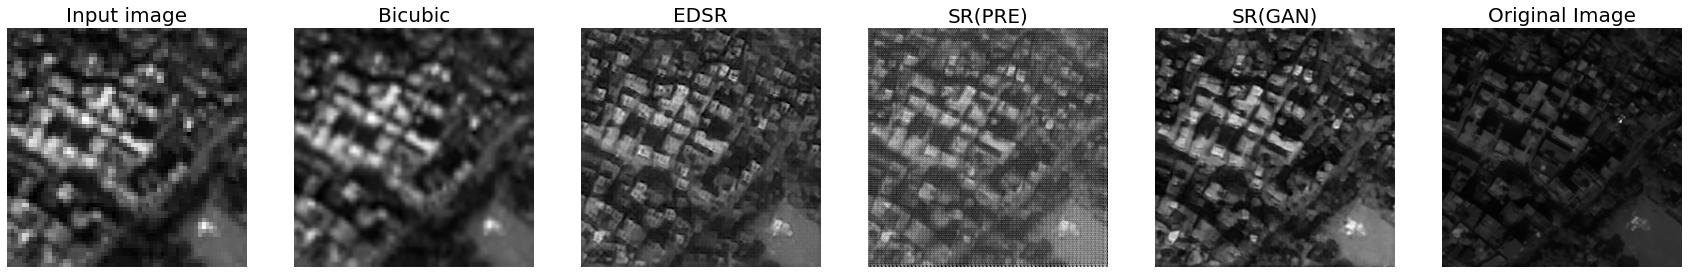

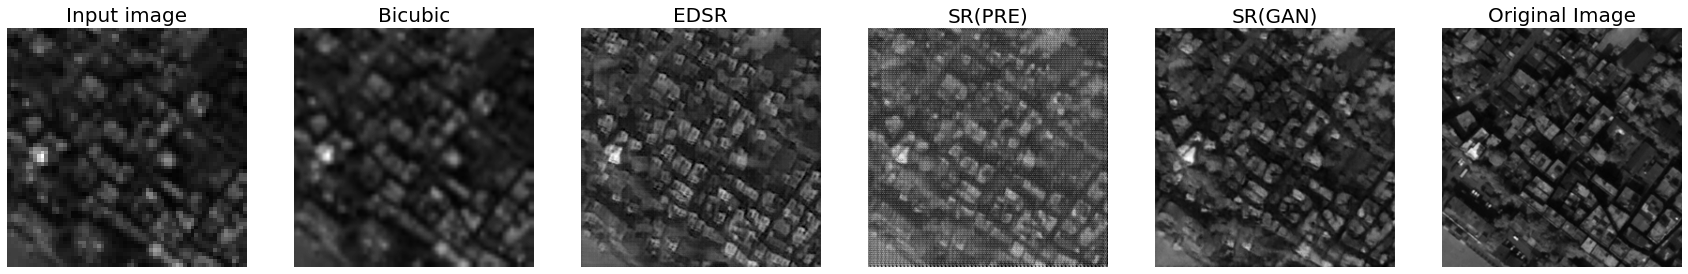

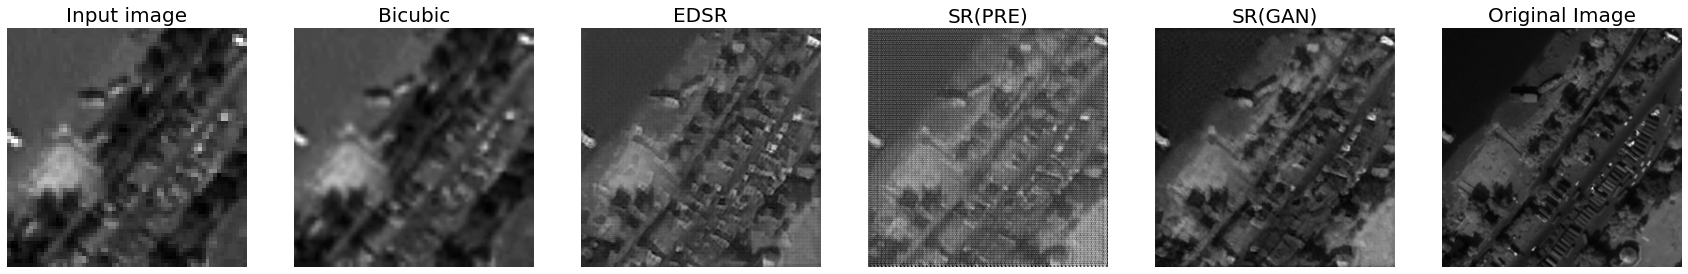

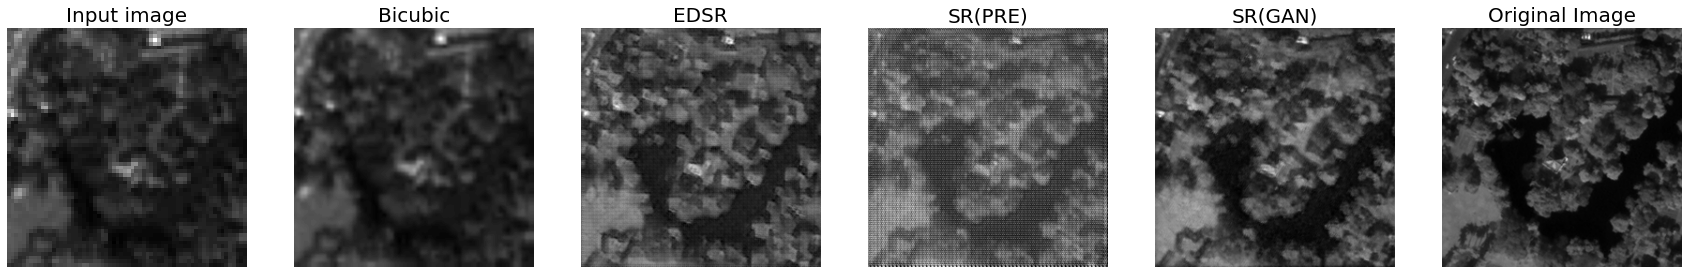

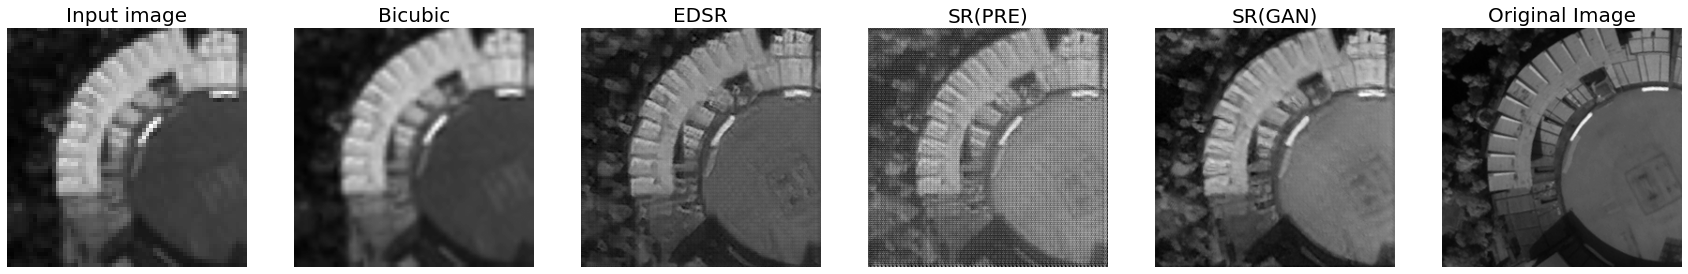

In [43]:
###  Image visualizations

# Display setup
def display(img1,img2,img3,img4, img5,img6):
    
  fig = plt.figure(figsize=(30, 15))

  ax1 = fig.add_subplot(1, 6, 1) 
  plt.title('Input image', fontsize=20)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 6, 2)
  plt.title('Bicubic', fontsize=20)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, 6, 3) 
  plt.title('EDSR', fontsize=20)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, 6, 4)
  plt.title('SR(PRE)', fontsize=20)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, 6, 5)
  plt.title('SR(GAN)', fontsize=20)
  ax5.axis('off')
  ax6 = fig.add_subplot(1, 6, 6)
  plt.title('Original Image', fontsize=20)
  ax6.axis('off')
  ax1.imshow(img1,cmap = 'gray')
  ax2.imshow(img2,cmap = 'gray')
  ax3.imshow(img3,cmap = 'gray')
  ax4.imshow(img4,cmap = 'gray')
  ax5.imshow(img5,cmap = 'gray')
  ax6.imshow(img6,cmap = 'gray')

def imread(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  r = img[0]
  g = img[1]
  b = img[2]
  rCCC = scaleCCC(r)
  gCCC = scaleCCC(g)
  bCCC = scaleCCC(b)
  img = np.dstack((rCCC,gCCC,bCCC))
  return img

def imread_bi(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  r = img[2]
  g = img[1]
  b = img[0]
  rCCC = scaleCCC(r)
  gCCC = scaleCCC(g)
  bCCC = scaleCCC(b)
  img = np.dstack((rCCC,gCCC,bCCC))
  return img

def imread_hr(img_path):
  img = rasterio.open(img_path)
  img = img.read()
  img = img[0]
  return img

# Input and results folder
input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR-New/'
result_presrgan = '/results/PRE-New/'
result_srgan =  '/results/GAN-New/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)
    


# Print images
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread(out_edsr)
  img_pre = imread(out_pre)
  img_gan = imread(out_gan)
  img_bi = imread_bi(out_bi)
  display(img_input[:,:,0],img_bi[:,:,0],img_edsr[:,:,0],img_pre[:,:,0],img_gan[:,:,0],img_original)

### Peak Signal-to-Noise Ratio (PSNR) Comperison:

In [96]:
from math import log10, sqrt

psnr_list = []

input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR-New/'
result_presrgan = '/results/PRE-New/'
result_srgan =  '/results/GAN-New/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)
    
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def psnr(original_img,img1,img2,img3,img4):
    psnr1 = PSNR(original_img, img1)
    psnr2 = PSNR(original_img, img2)
    psnr3 = PSNR(original_img, img3)
    psnr4 = PSNR(original_img, img4)
    psnr_list.append([psnr1,psnr2,psnr3,psnr4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  psnr(img_original,img_bi,img_edsr,img_pre,img_gan)
psnr_array = np.array(psnr_list)
psnr_array = np.append(psnr_array, np.mean(psnr_list,axis = 0).reshape(1,4),axis = 0)
    
df_psnr_new = pd.DataFrame(psnr_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_psnr_new['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_psnr_new['Avg'] = np.mean(psnr_array,axis = 1)
df_psnr_new.set_index('Images',inplace = True)
df_psnr_new.style.set_caption("PSNR Table")

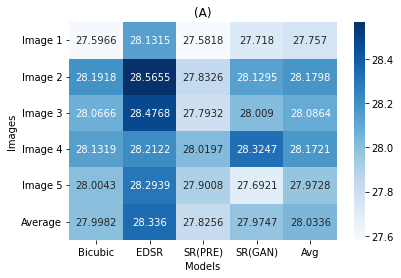

In [97]:
import seaborn as sns
ax = sns.heatmap(df_psnr_new, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='(A)')

### Structural Similarity Index (SSIM) Comperison:

In [92]:
from skimage.metrics import structural_similarity
score = []


input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR-New/'
result_presrgan = '/results/PRE-New/'
result_srgan =  '/results/GAN-New/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)

def ssim(original_img,img1,img2,img3,img4):
    score1 = structural_similarity(original_img, img1, data_range=img1.max() - img1.min())
    score2 = structural_similarity(original_img, img2, data_range=img2.max() - img2.min())
    score3 = structural_similarity(original_img, img3, data_range=img3.max() - img3.min())
    score4 = structural_similarity(original_img, img4, data_range=img4.max() - img4.min())
    score.append([score1,score2,score3,score4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  ssim(img_original,img_bi,img_edsr,img_pre,img_gan)
    

ssim_array = np.array(score)
ssim_array = np.append(ssim_array, np.mean(score,axis = 0).reshape(1,4),axis = 0)
    
df_ssim_new = pd.DataFrame(ssim_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_ssim_new['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_ssim_new['Avg'] = np.mean(ssim_array,axis = 1)
df_ssim_new.set_index('Images',inplace = True)
df_ssim_new.style.set_caption("SSIM Table")

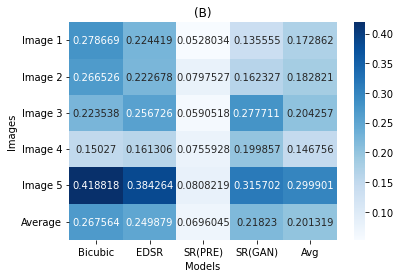

In [93]:
import seaborn as sns
ax = sns.heatmap(df_ssim_new, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='(B)')

### Root Mean Squered Error (RMSE) Comperison:

In [90]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
score = []

input_folder = '/LowResImages/'
original_folder = '/OriginalImages/'
result_edsr = '/results/EDSR-New/'
result_presrgan = '/results/PRE-New/'
result_srgan =  '/results/GAN-New/'
results_bicubic = '/results/Bicubic/'


input_list = []
original_list = []
output_edsr = []
output_presgan = []
output_srgan =[]
output_bicubic = []

for img in images:
    input_list.append(input_folder+img)
    original_list.append(original_folder+img)
    output_edsr.append(result_edsr+img)
    output_presgan.append(result_presrgan + img)
    output_srgan.append(result_srgan + img)
    output_bicubic.append(results_bicubic + img)

def err(original_img,img1,img2,img3,img4):
    score1 = rmse(original_img, img1)
    score2 = rmse(original_img, img2)
    score3 = rmse(original_img, img3)
    score4 = rmse(original_img, img4)
    
    score.append([score1,score2,score3,score4])
    
for input_path,original_path,out_edsr,out_pre,out_gan,out_bi in zip(input_list,original_list,output_edsr,output_presgan,output_srgan,output_bicubic):
  img_input = imread_hr(input_path)
  img_original = imread_hr(original_path)
  img_edsr = imread_hr(out_edsr)
  img_pre = imread_hr(out_pre)
  img_gan = imread_hr(out_gan)
  img_bi = imread_hr_bi(out_bi)
  err(img_original,img_bi,img_edsr,img_pre,img_gan)
    
rmse_array = np.array(score)
rmse_array = np.append(rmse_array, np.mean(score,axis = 0).reshape(1,4),axis = 0)
    
df_rmse_new = pd.DataFrame(rmse_array, columns = ['Bicubic','EDSR','SR(PRE)','SR(GAN)'])
df_rmse_new['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_rmse_new['Avg'] = np.mean(rmse_array,axis = 1)
df_rmse_new.set_index('Images',inplace = True)
df_rmse_new.style.set_caption("RMSE Table")

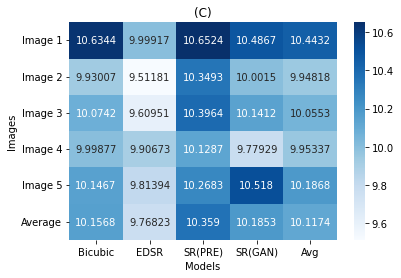

In [91]:
import seaborn as sns
ax = sns.heatmap(df_rmse_new, annot=True,fmt='g',cmap="Blues").set(xlabel='Models',title='(C)')

### All metrics comperison

In [107]:
col = ['PSNR before traing','PSNR after training','SSIM before traing','SSIM after training','RMSE before traing','RMSE after training']
row =['Image 1','Image 2','Image 3','Image 4','Image 5']

In [142]:
df_score = pd.DataFrame(np.array([np.array(df_psnr['Avg']),np.array(df_psnr_new['Avg']),np.array(df_ssim['Avg'])*100,np.array(df_ssim_new['Avg'])*100,np.array(df_rmse['Avg']),np.array(df_rmse_new['Avg'])]).T,columns = col)
df_score['Images']=['Image 1','Image 2','Image 3','Image 4','Image 5','Average']
df_score

PSNR before traing  PSNR after training  SSIM before traing  \
0           27.634041            27.756979           19.946317   
1           28.167963            28.179839           19.897881   
2           28.083090            28.086395           18.605519   
3           28.116585            28.172114           11.967262   
4           28.016683            27.972784           38.643617   
5           28.003672            28.033622           21.812119   

   SSIM after training  RMSE before traing  RMSE after training   Images  
0            17.286158           10.588630            10.443178  Image 1  
1            18.282101            9.957330             9.948178  Image 2  
2            20.425660           10.055094            10.055314  Image 3  
3            14.675642           10.016399             9.953372  Image 4  
4            29.990134           10.132268            10.186759  Image 5  
5            20.131939           10.149944            10.117360  Average

<AxesSubplot:xlabel='Images'>

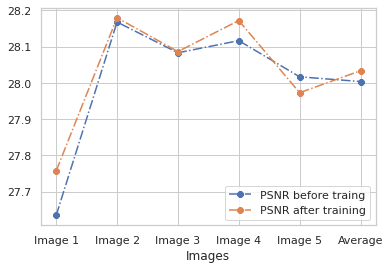

In [144]:
sns.set(style = "whitegrid",font_scale=1)
df_score[['PSNR before traing','PSNR after training','Images']].plot(x='Images', y=['PSNR before traing','PSNR after training'],marker="8",ls = '-.')

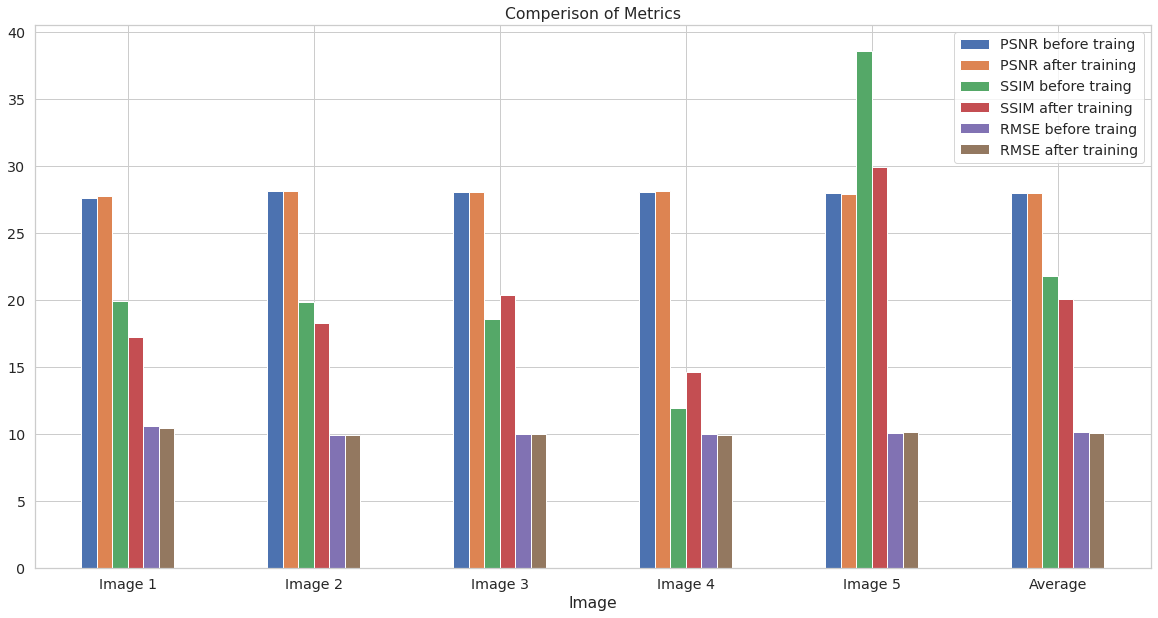

In [116]:
import seaborn as sns
sns.set(style = "whitegrid",font_scale=1.3)
_ =df_score.plot(x='Image', y=col, kind="bar",figsize=(20, 10),rot=0,title = 'Comperison of Metrics')

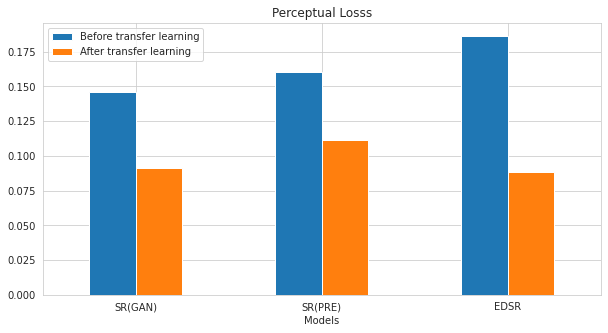

In [105]:
import seaborn as sns
sns.set_style("whitegrid")
df_perceptual = pd.DataFrame(np.array([[0.1458,0.0910],[0.1601,0.1111],[0.1863,0.0885]]),columns = ['Before transfer learning','After transfer learning'])
df_perceptual['Models'] = ['SR(GAN)','SR(PRE)','EDSR']
_ =df_perceptual.plot(x='Models', y=['Before transfer learning','After transfer learning'], kind="bar",figsize=(10, 5),rot=0,title = 'Perceptual Losss')

# Explainability

## EDSR Explainability

In [59]:
# Model Summary
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_25 (Lambda)              (None, None, None, 3 0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_226 (Conv2D)             (None, None, None, 6 1792        lambda_25[0][0]                  
__________________________________________________________________________________________________
conv2d_227 (Conv2D)             (None, None, None, 6 36928       conv2d_226[0][0]                 
_______________________________________________________________________________________________

### Filter Kernel Visualization

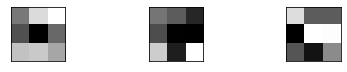

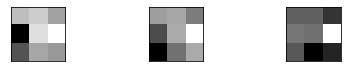

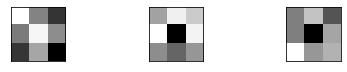

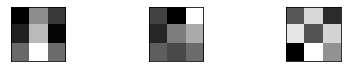

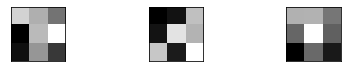

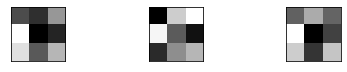

In [44]:
### Visualization of 3rd Layer Filter Kernel
model.load_weights('EDSR/weights_new/edsr-weights.h5')
filters, biases = model.layers[3].get_weights()
# normalizing filter values to 0-1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# ploting first few filters (1-6)
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    plt.figure(figsize=(7, 7))
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

### Visualization of Feature Map

In [77]:
def scaleCCC(x):
    return((x - np.nanpercentile(x, 30))/(np.nanpercentile(x, 70) - np.nanpercentile(x,30)))

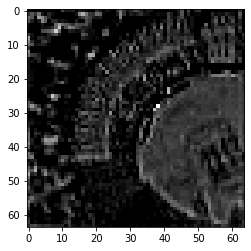

In [97]:
pixvals = feature_maps[0, :, :, 2]

pixvals = ((pixvals - pixvals.min()) / (pixvals.max()-pixvals.min())) * 255

plt.imshow(pixvals, cmap = 'gray')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


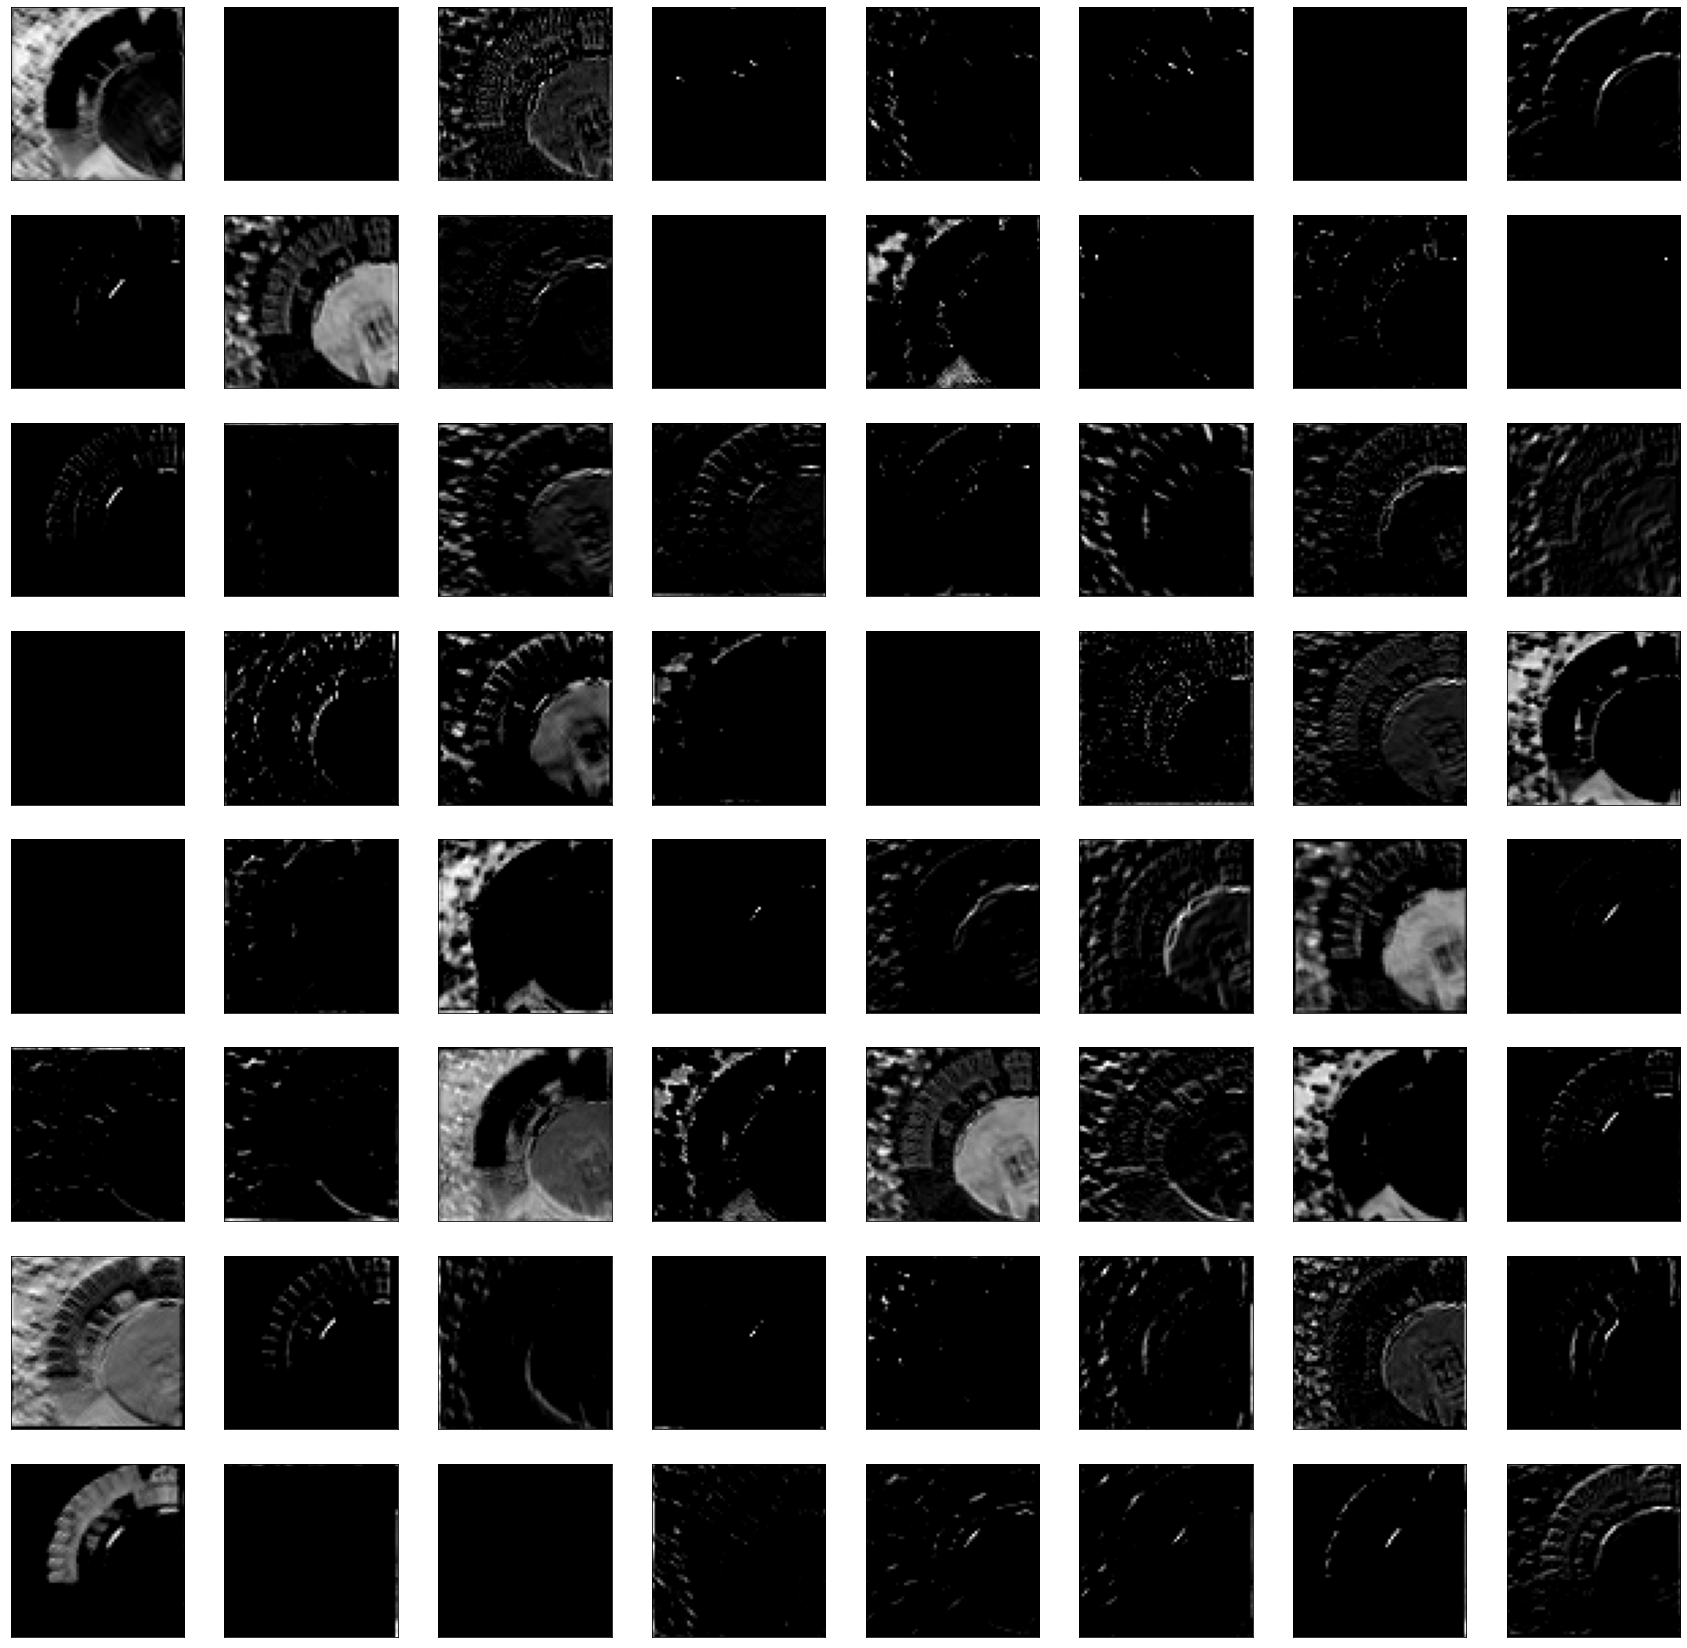

In [45]:
### Visualization of 3rd Layer Feaure Map
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

model_check = Model(inputs=model.inputs, outputs=model.layers[3].output)
model_check.summary()

img = np.expand_dims(lr_img_array_list[4], axis=0)
feature_maps = model_check.predict(img)
square = 8
ix = 1
plt.figure(figsize=(30, 30))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in spectral
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
#plt.show()
plt.savefig('foo.tif')

## SRGAN Explainability

In [62]:
# Model Summary
gan_generator.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, None, None, 3 0           input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_298 (Conv2D)             (None, None, None, 6 15616       lambda_33[0][0]                  
__________________________________________________________________________________________________
p_re_lu_95 (PReLU)              (None, None, None, 6 64          conv2d_298[0][0]                 
____________________________________________________________________________________________

### Filter Kernel Visualization

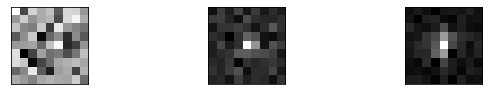

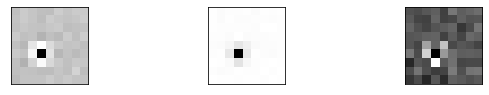

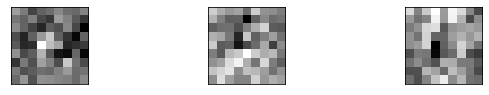

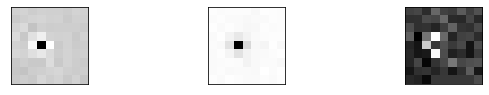

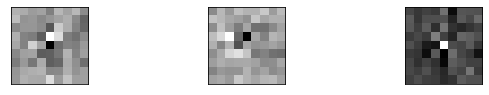

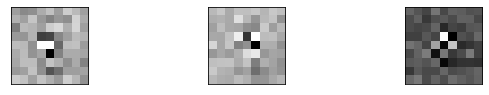

In [46]:
### Visualization of 2nd Layer Filter Kernel
gan_generator.load_weights('SRGAN/weights_new/gan_generator.h5')
filters, biases = gan_generator.layers[2].get_weights()
# normalizing filter values to 0-1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# ploting first few filters (1-6)
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    plt.figure(figsize=(10, 10))
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

### Visualization of Feature Map

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,616
Trainable params: 15,616
Non-trainable params: 0
_________________________________________________________________


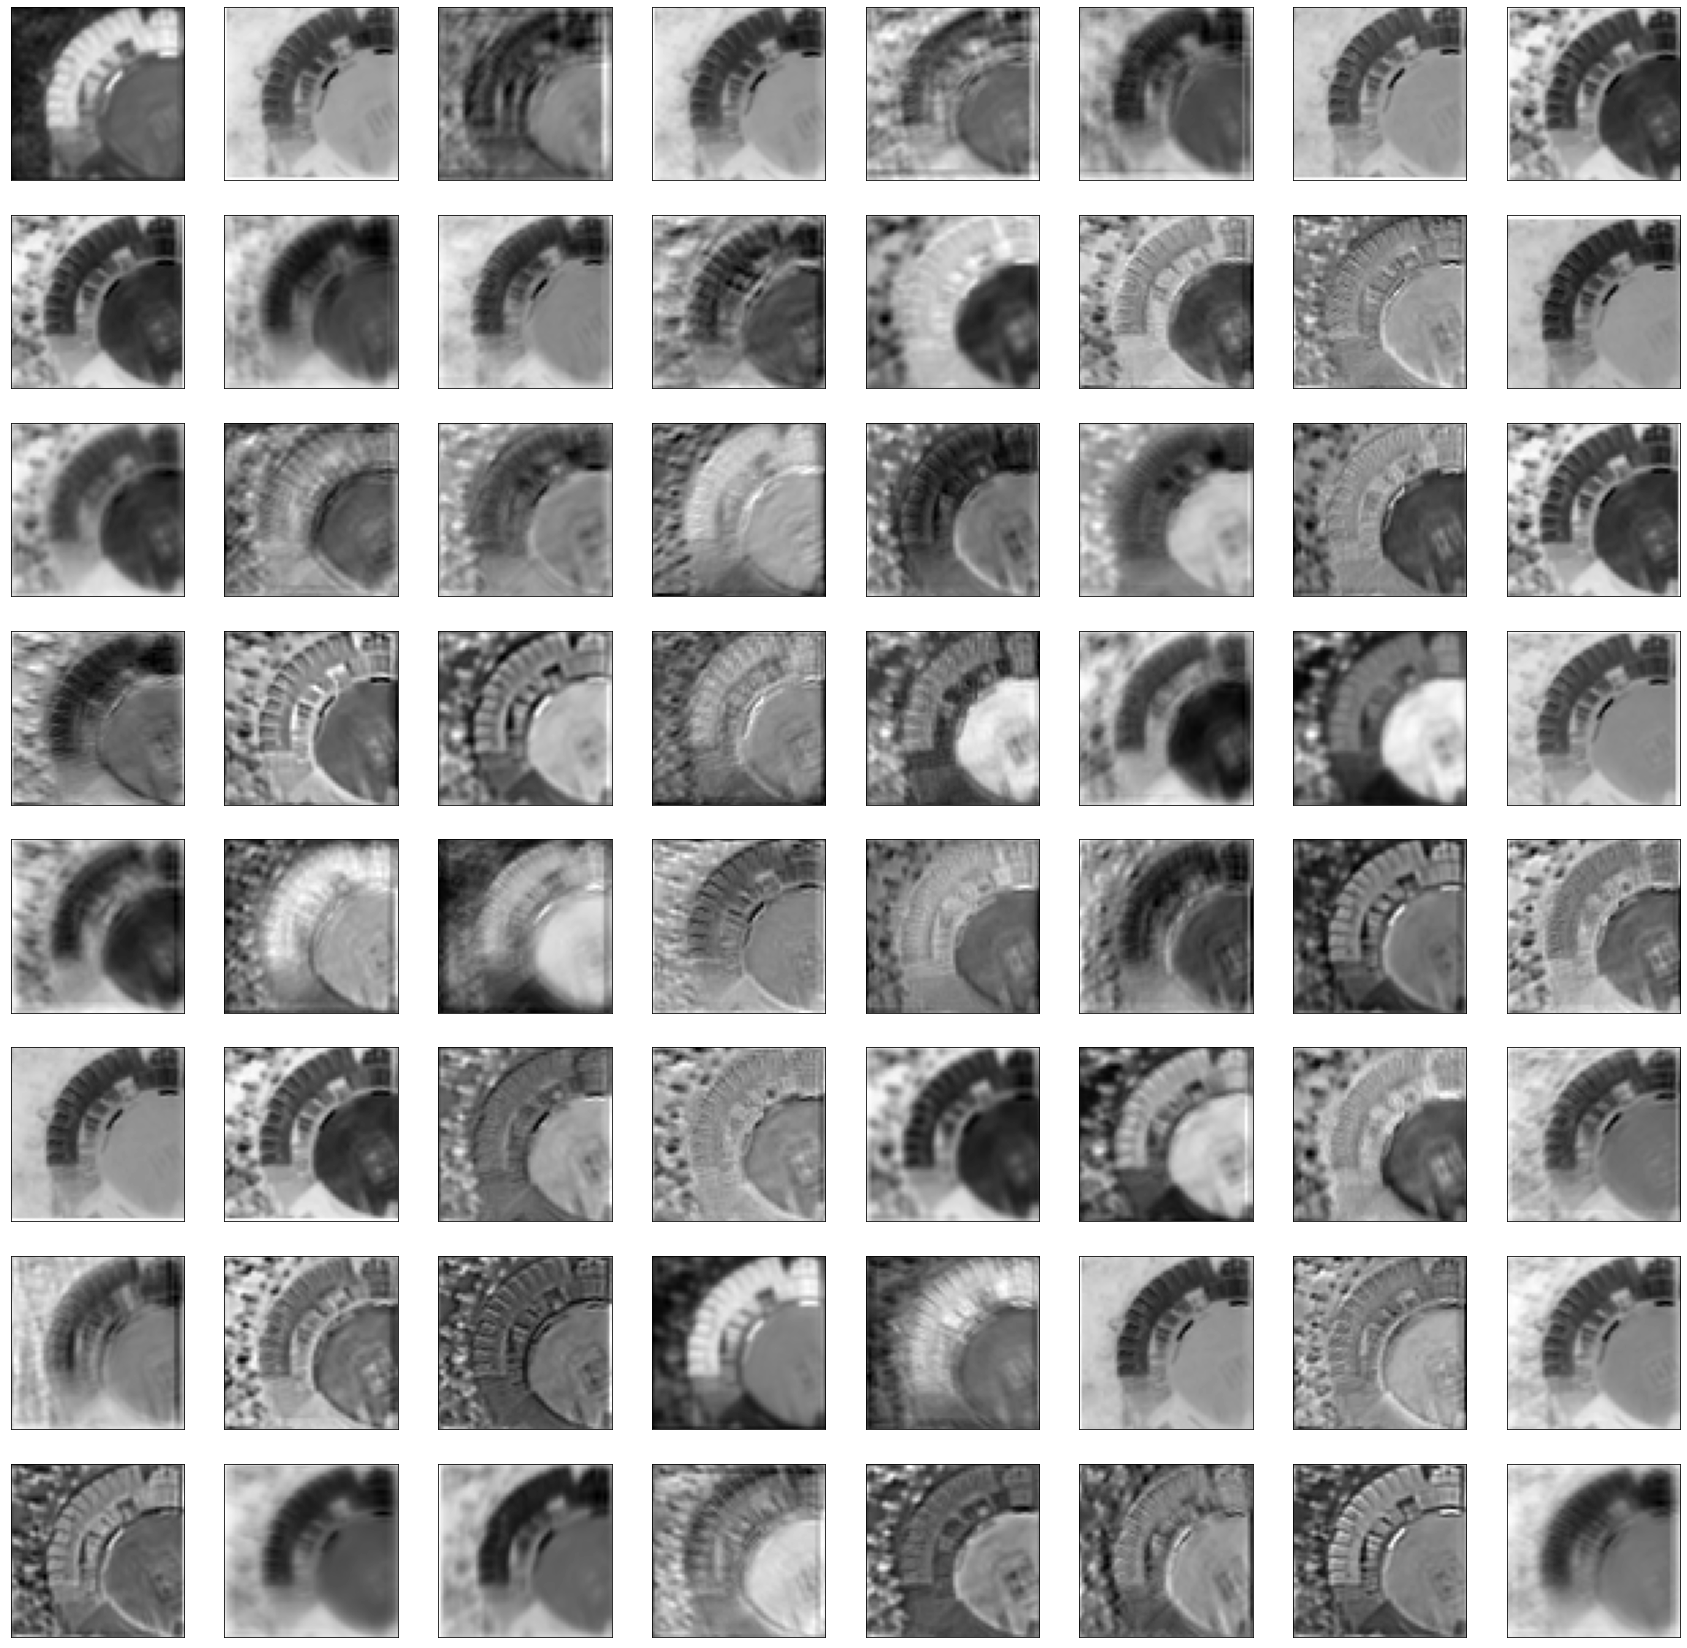

In [47]:
### Visualization of 2nd Layer Feaure Map
model_check = Model(inputs=gan_generator.inputs, outputs=gan_generator.layers[2].output)
model_check.summary()

img = np.expand_dims(lr_img_array_list[4], axis=0)
feature_maps = model_check.predict(img)
square = 8
ix = 1
plt.figure(figsize=(30, 30))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in spectral
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()